<a href="https://colab.research.google.com/github/JhonnyLimachi/Sigmoidal/blob/main/41_Time_Series_com_Prophet_do_Facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**


---

## Séries Temporais - Facebook Prophet

Nossa ferramenta, no momento para fazer previsões em séries temporais será o `Prophet`, que foi desenvolvido pelo Facebook.

<center>
<img src="https://www.clickz.com/wp-content/uploads/2017/08/crystal-ball.png" width="50%"></center>

O Prophet é bastante robusto, simples e fácil de usar. Vocês vão encontrar na internet exemplos de código utilizando o Prophet sem nem se preoucupar se a Série Temporal é estacionária. Em alguns casos o resultado é bom, mas nem sempre.

Aqui no Sigmoidal, dentro da [Escola de Data Science](https://escola.sigmoidal.ai) nós já tivemos aulas extensivas e técnicas sobre o assunto, e por isso não vou me aprofundar, mas vou trazer aqui uma parte essencial do texto do Carlos que trata do assunto:

### Testes Estatísticos e ARIMA
um pré-requisito para que possamos fazer previsões em cima de uma TS é ela ser estacionária.

De maneira simplificada, ser estacionária significa ter a **média, variância e covariância** permanecendo **constante** ao longo da dimensão temporal. Vamos entender visualmente o que isso significa.

<center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns5-e1536673990684.png" width="50%"></center>

No primeiro plot, há uma tendência de alta. Ou seja, a sua média está aumentando conforme o tempo passa. No segundo plot, apesar de não haver uma variação na tendência, a variância (não constante) está interferindo na sua amplitude. Por fim, o último exibe o comportamento típico de quando a covariância varia em função do tempo.

**E como se pareceria uma série estacionária?**

Uma TS com média, variância e covariância constante seria parecida com o plot abaixo.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns6-e1536674898419.png" width="20%"></center>

**Como verificar se uma TS é estacionária?**

Há muitas maneiras se fazer essa verificação. Por exemplo:

* **Olhar os plots -** Em muitos casos, durante a análise exploratória você já vai identificar visualmente se uma TS é estacionária ou não.
* **Resumo estatístico -** Você pode gerar um resumo com as principais informações estatísticas da TS, e verificar se há algum indício da estacionaridade.
* **Testes estatísticos -** São testes que possuem a capacidade de nos dizer se uma TS é estacionária ou não, sempre se baseando em métodos científicos.

Nesta projeto, mais pra frente, realizaremos um teste estatístico específico para identificar se nossa TS é estacionária ou não, o teste ***Augmented Dickey Fuller (ADF)***

### Teste ADF

O ADF é um dos testes estatísticos mais usados para TS. Suas hipóteses nula e alternativa são:

* A Hipótese Nula ($H_0$) do teste é que a TS **não é estacionária**. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) **rejeita a hipótese nula**, ou seja, que a TS é estacionária.

Vamos ver como isso vai acontecer no nosso projeto específico.


## Preparando os Dados

Primeiro de tudo, precisamos preparar os dados para serem utilizados com o Prophet. Ele precisa de um tipo muito específico de dataframe para funcionar. Precisamos de:

* Data como uma coluna chamada `ds`.
* Vendas como uma coluna chamada `y`.

No caso específico desse notebook, nós já trouxemos os dados dessa forma, mas normalmente precisaremos fazer um tratamento do nosso conjunto para chegar a esse formato.

In [1]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importando o Prophet
from prophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
# importando os dados
df_ts = pd.read_csv('https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/df_ts.csv')
df_ts.head()

,ds,y
0,2018-01-01,43432
1,2018-01-02,43181
2,2018-01-03,43298
3,2018-01-04,42216
4,2018-01-05,42001


## Teste ADF

Diferente de alguns projetos que vemos com o Prophet, vamos fazer o teste para descobrir se nossa série é estacionária. O teste utilizado será o ***Augmented Dickey Fuller (ADF)***.

Como bem disse o Carlos:
> Normalmente, rejeitamos $H_0$ quando o *p-value* é menor ou igual a um determinado nível de significância. Normalmente, esse nível de significância é igual a 0.01 (1%), 0.05 (5%) ou até mesmo 0.1 (10%).

> Quanto menor o *p-value*, mais evidências contra a hipótese nula você tem. Por exemplo, caso seja usado $\text{p-value} = 0.05$, rejeitamos a $H_0$ com um nível de confiança de 95%.

> Caso o valor do teste fique acima do *threshold*, falharemos em rejeitar a hipótese nula. **Atenção, isso não significa que $H_0$ é verdadeira.** Significa apenas que o experimento não encontrou evidências para rejeitá-la.

Vamos ver como a nossa série se sai.

In [3]:
# importanto o pacote
from statsmodels.tsa.stattools import adfuller
# extraindo os valores
X = df_ts.y

# aplicando o ADF e imprimindo os resultados.
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value));

Augmented Dickey–Fuller
Statistical Test: -2.3601
P Value: 0.1533303754
Critical Values:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


## Tamanho das Previsões

Ao lidar com previsões em Séries Temporais precisamos entender que quanto maior o período que estamos tentando prever, menos confiança teremos nos resultados. Dessa forma, mesmo tendo anos de registros de vendas, vamos fazer as nossas previsões para um período de 30 dias.

In [4]:
# definindo o tamanho da previsão para trinta dias
prediction_size = 30
train_df = df_ts[:-prediction_size]

Agora que temos o nosso conjunto de teste, vamos instanciar e treinar nosso modelo, e fazer nossas previsões.

In [5]:
# instanciando o modelo
b = Prophet()

# treinando o modelo
b.fit(train_df)

# fazendo previsões
future = b.make_future_dataframe(periods=prediction_size)

forecast = b.predict(future)

forecast.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp754n1vlh/ja8r62u4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp754n1vlh/aa2t2puh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53274', 'data', 'file=/tmp/tmp754n1vlh/ja8r62u4.json', 'init=/tmp/tmp754n1vlh/aa2t2puh.json', 'output', 'file=/tmp/tmp754n1vlh/prophet_modelakfl7d64/prophet_model-20240413015239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,45499.039179,40895.330554,43956.433029,45499.039179,45499.039179,-3083.562908,-3083.562908,-3083.562908,-899.856816,-899.856816,-899.856816,-2183.706092,-2183.706092,-2183.706092,0.0,0.0,0.0,42415.476271
1,2018-01-02,45498.081259,41100.703866,44306.666288,45498.081259,45498.081259,-2800.707332,-2800.707332,-2800.707332,-616.589827,-616.589827,-616.589827,-2184.117505,-2184.117505,-2184.117505,0.0,0.0,0.0,42697.373927
2,2018-01-03,45497.123338,41467.070147,44523.658772,45497.123338,45497.123338,-2461.477525,-2461.477525,-2461.477525,-275.759820,-275.759820,-275.759820,-2185.717704,-2185.717704,-2185.717704,0.0,0.0,0.0,43035.645813
3,2018-01-04,45496.165418,41878.894634,45110.667941,45496.165418,45496.165418,-1982.107934,-1982.107934,-1982.107934,206.207569,206.207569,206.207569,-2188.315503,-2188.315503,-2188.315503,0.0,0.0,0.0,43514.057483
4,2018-01-05,45495.207497,42586.179068,45695.479682,45495.207497,45495.207497,-1340.649767,-1340.649767,-1340.649767,851.039599,851.039599,851.039599,-2191.689366,-2191.689366,-2191.689366,0.0,0.0,0.0,44154.557731


O Prophet traz em seu resultado de previsões diversas informações, entre elas, temos o `yhat`, que são nossas previsões. Além disso temos também os limites inferiores e superiores (`yhat_lower`, `yhat_upper`, respectivamente) entre outras informações que podem ser úteis para um projeto real.

Visualizar as previsões também é super fácil, como podemos ver abaixo:

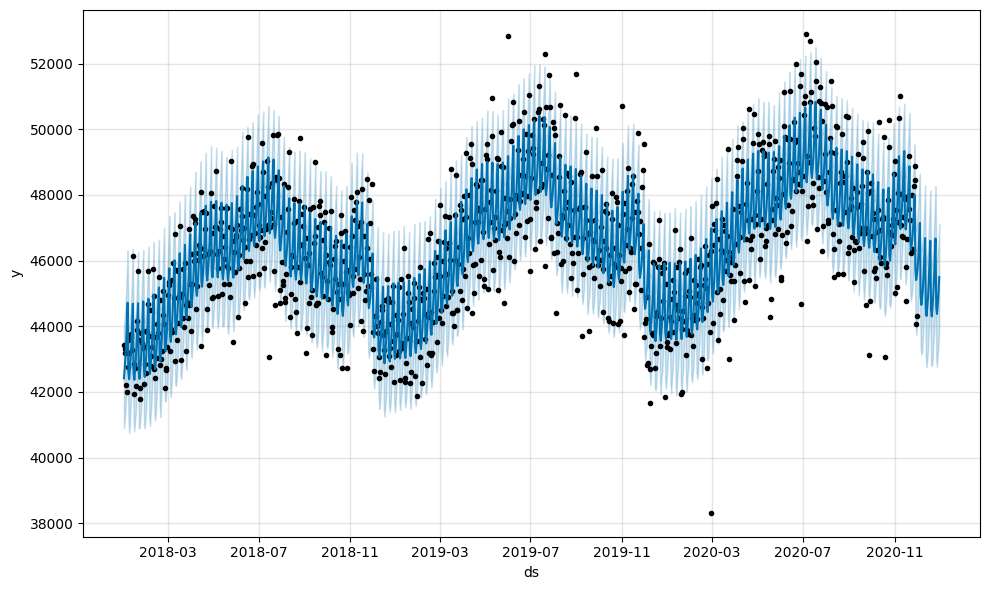

In [6]:
# plotando as previsões
b.plot(forecast).savefig('forecast_non_stationary.png')

Além disso, também podemos plotar os componentes da nossa previsão.

Abaixo, podemos ver:

* Tendência Geral
* Tendência Semanal
* Tendência Anual


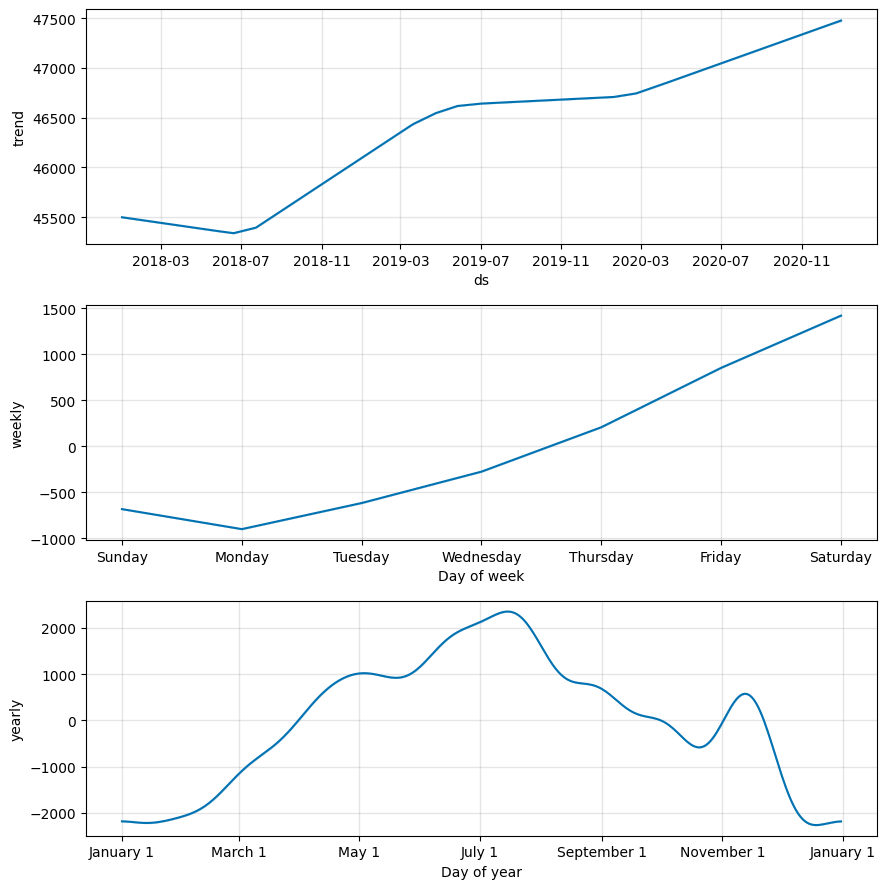

In [7]:
# plotando componentes
b.plot_components(forecast).savefig('non_st_components.png')

## Conclusões - Série Não-Estacionária
Tudo isso parece lindo e perfeito, mas como saber se nossas previsões estão boas de verdade?

Para isso utilizaremos as seguintes métricas:

* Mean Absolute Percentage Error - Mostra quanto as nossas previsões diferem do valor real em porcentagem.
* Mean Absolute Error - Valor absoluto do nosso erro na previsão em relação à série real.

Abaixo temos uma função para calcular o MAPE e MAE da nossa série.

In [8]:
# definindo a função
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_ts, forecast)

def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# imprimindo o MAPE e MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE nan
MAE nan
